In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import torch.nn.functional as F
from torch.nn.functional import conv2d
import torch.nn as nn
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

from crf.utils import read_image, read_pfm, read_pgm

In [2]:
from crf.gaussian_matrix import GaussianBlur, gaussian_blur,box_filter

In [3]:
img1 = read_image('imL.png')
img2 = read_image('imR.png')

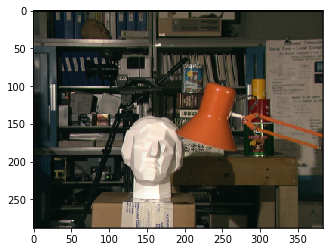

In [4]:
plt.imshow(img1)

In [5]:
img_torch = torch.from_numpy(img1)

In [6]:
src = img_torch.clone().detach().requires_grad_(False).float()
alpha = nn.Parameter(torch.log(torch.tensor(30.)).float())
sigma = lambda: torch.exp(alpha)

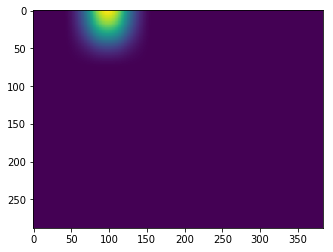

In [7]:
h,w = img_torch.shape[:2]
e0 = torch.zeros(h,w)
e0[20,100] = 1
by = GaussianBlur.apply(e0,20,0)
bxy = GaussianBlur.apply(by,20,1)
plt.imshow(bxy.data.numpy())

In [8]:
((gaussian_blur(gaussian_blur(e0,21,0),21,1) - bxy.clone().detach())**2).sum()

tensor(1.3701e-06)

In [ ]:
optimizer = torch.optim.Adam([alpha],lr=1e-1)#,betas=(.9,.9))
for i in range(5):
    optimizer.zero_grad()
    loss = ((gaussian_blur(gaussian_blur(e0,sigma(),0),sigma(),1) - bxy.clone().detach())**2).sum()
    loss.backward()
    if not i%1:
        print(f"L={loss.data.numpy()},S={sigma().data.numpy()},g={alpha.grad.data.numpy()}")
    optimizer.step()

In [9]:
def testfunc():
    ((gaussian_blur(gaussian_blur(e0,sigma(),0),sigma(),1) - bxy.clone().detach())**2).sum().backward()

In [ ]:
with torch.autograd.profiler.profile() as prof:
    testfunc()
#print(prof)

In [13]:
%timeit testfunc()

24.8 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%lprun -f box_filter testfunc()

Timer unit: 1e-06 s

Total time: 0.002625 s
File: /home/marc/depth-estimation/crf/gaussian_matrix.py
Function: box_filter at line 85

Line #      Hits         Time  Per Hit   % Time  Line Contents
    85                                           def box_filter(array,r,dim):
    86         6         27.0      4.5      1.0      m = len(array.shape)
    87         6          6.0      1.0      0.2      padding = ((0,0,)*dim + (r,r,)+(0,0,)*(m-dim-1))
    88         6        832.0    138.7     31.7      padded_arr = F.pad(array,padding[::-1]) #zero padding
    89                                               # try:
    90                                               #     padded_arr = F.pad(array,padding[::-1],mode='replicate') #bug with replicate padding on nd
    91                                               # except (AssertionError,NotImplementedError):
    92                                               #     padded_arr = F.pad(array[None,None],padding[::-1],mode='replicate')[0,0]


In [ ]:
bxy[bxy>1e-5]

In [ ]:
plt.imshow((gaussian_blur(gaussian_blur(e0,sigma,0),sigma,1)-bxy).data.numpy())

In [ ]:
blurred = GaussianBlur.apply(img_torch,5,0)

In [ ]:
plt.imshow(blurred.data.numpy())

In [ ]:
e0.shape

In [ ]:
from torch.autograd import gradcheck
src = img_torch.clone().detach().requires_grad_(False).double()[::16,::16]
sigma = torch.tensor(3.,requires_grad=True).double()
gradcheck(GaussianBlur.apply,(src,sigma,0),eps=1e-5,rtol=5e-4,atol=1e-5)

In [ ]:
np.arange(10)[:-6]